In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import gpytorch
import lbg_forecast.priors_gp_massfunc as gpmf

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
782.5972602202451
722.3770535826123
661.8381031802912
601.4083395554899
541.520656055118
482.582513629306
425.0643693641932
369.5054987369797
316.3923954890154
266.2280018039111
219.50919882094786
176.70359043252526
138.18072648893687
104.32442045569546
75.34901655983676
51.39271946616273
32.47952138389325
18.448906523299822
9.02426015451416
3.757202886603295
2.073368194460002
2.023200765976409
1.9796935325769227
1.9413410926243932
1.9074227731817812
1.8773327241346858
1.850559553866144
1.8266701910100949
1.8052963630834014
1.786123559023072
1.7688822653370126
1.753341022648153
1.7392998619668858
1.7265859180269834
1.7150487860865022
1.704557812679771
1.694998694702573
1.6862713304611214
1.6782879762252672
1.6709710643821174
1.6642524053189882
1.658071713937189
1.6523753093705726
1.6471157897300621
1.6422506720408179
1.6377424172788841
1.63355713

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


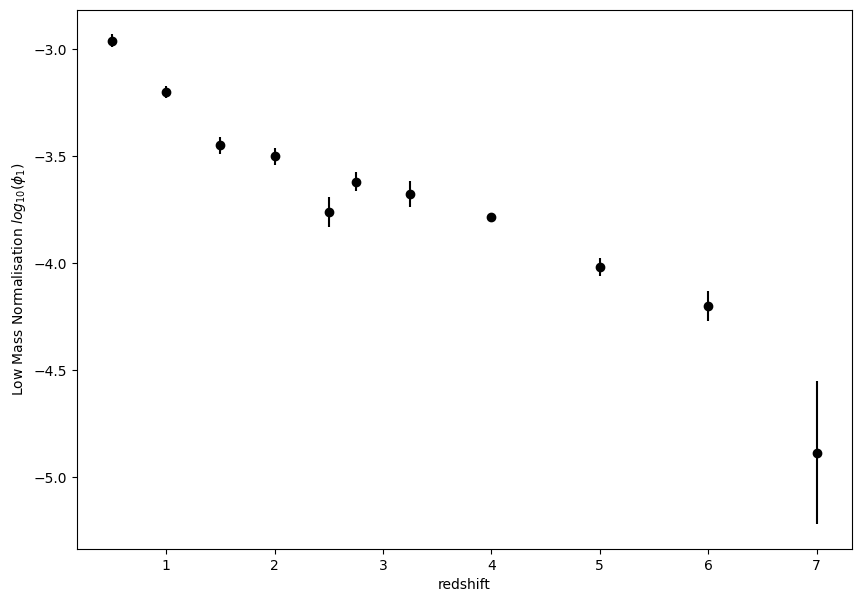

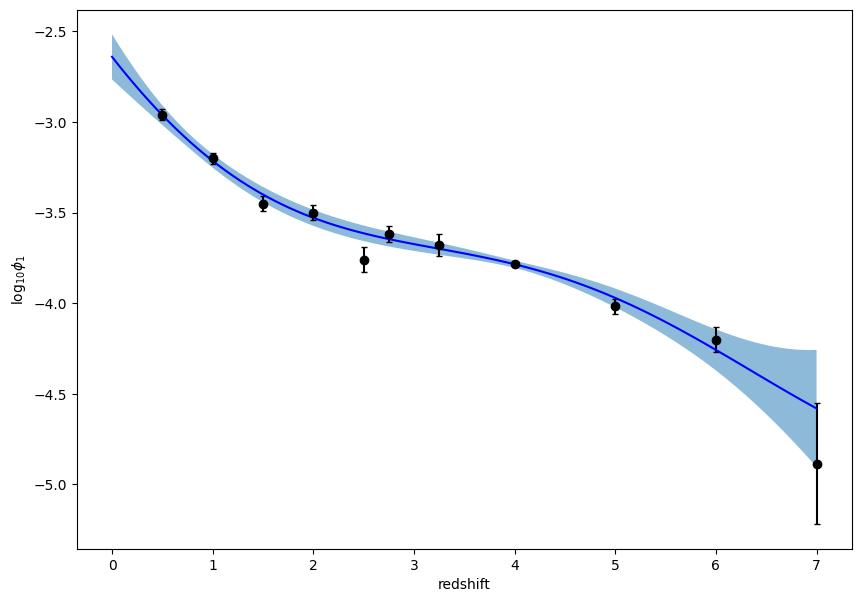

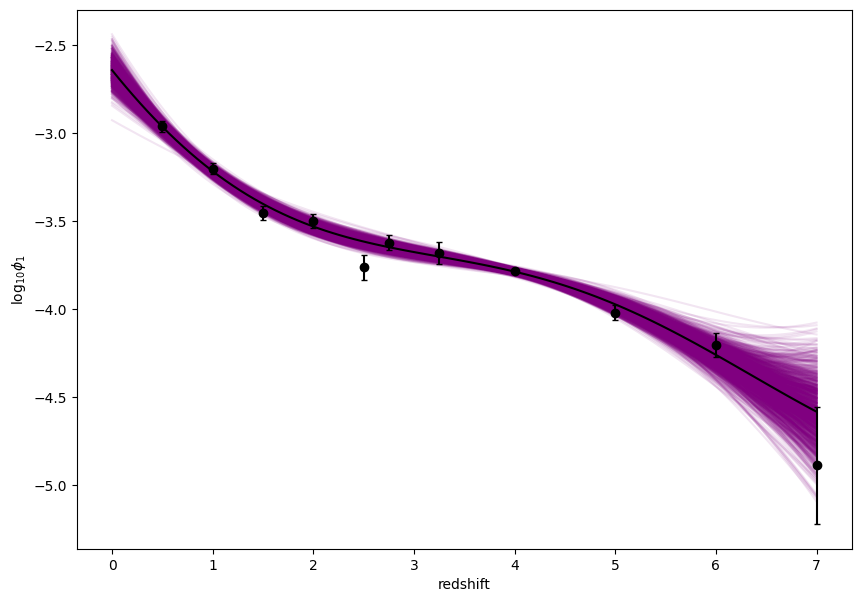

In [2]:
sorted_train_redshift, sorted_train_logphi1, sorted_train_logphi1_errs = gpmf.get_phi1_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_logphi1, sorted_train_logphi1_errs, torch.linspace(0, 7, 100), lengthscale=[2.0, 999.0], scalefactor=[-999, 999], lr=0.1, training_iter=20000, ylabel="$\mathrm{log}_{10}\phi_{1}$", name="phi1")


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
778.9260346610391
719.1689579392781
659.1462916639001
599.2300224790123
539.8129015846288
481.2885582723555
424.0350551949203
368.82942419197036
315.99946063021036
266.248857518967
219.55928236379424
176.86316744851322
138.5975464947777
104.6530103040729
75.76049817449201
51.971389053604845
33.09561650010446
19.111764436418063
9.707264949352263
4.518483124809023
2.8797960427773384
2.8558782622058545
2.8347512384593263
2.8157233208811907
2.7985579772443963
2.783043138780279
2.768991028466879
2.7562366747847986
2.7446362239432536
2.734064403225256
2.724411942513633
2.715583820525982
2.7074969420175625
2.7000790541643855
2.6932667583834182
2.687004527077099
2.6812438647720365
2.675942031584526
2.67106153710956
2.66656933471669
2.6624359082165214
2.658635552297857
2.65514499646082
2.6519434734232648
2.649012252222857
2.646333989596143
2.6438930982764

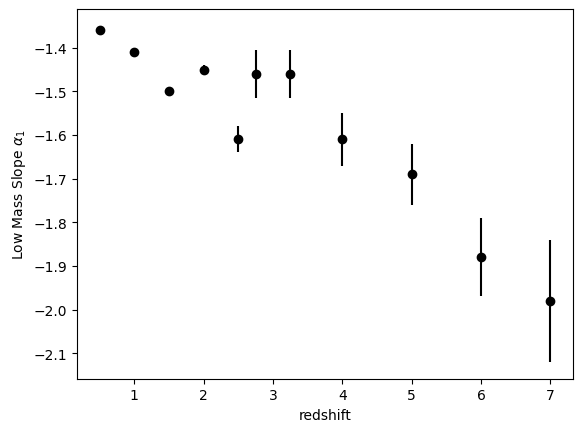

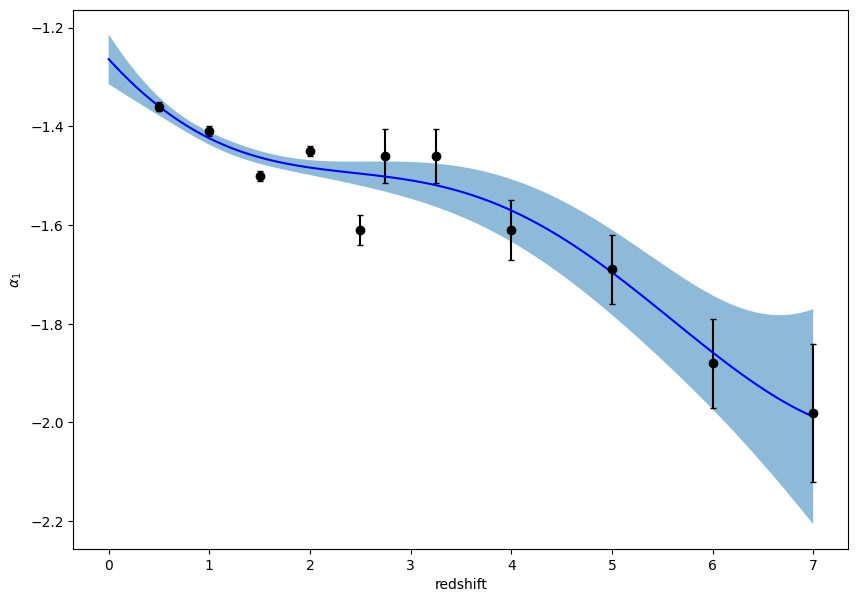

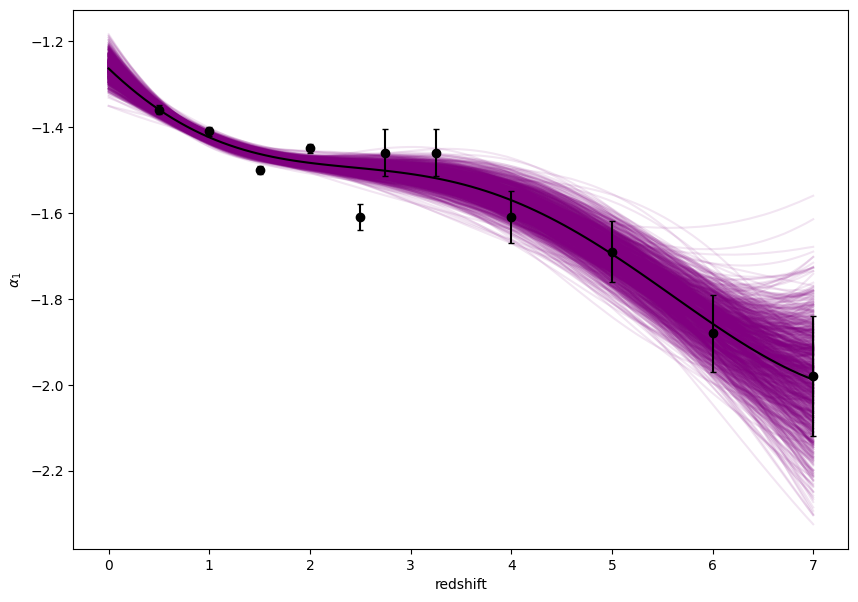

In [3]:
sorted_train_redshift, sorted_train_alpha1, sorted_train_alpha1_errs = gpmf.get_alpha1_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_alpha1, sorted_train_alpha1_errs, torch.linspace(0.0, 7.0, 100), lengthscale=[2.0, 9999.0], scalefactor=[-999, 999], lr=0.1, training_iter=20000, ylabel="$\\alpha_{1}$", name="alpha1")

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
810.5425821970045
747.0747210890296
683.8366890051241
621.1151893398581
559.224080437468
498.50171253543755
439.735581969906
382.82201608661273
328.53108683535976
277.53073826659215
229.7646565979155
186.41236848816973
147.30844480321778
112.84137814014076
83.2739512068497
58.887543316373815
39.59609595250698
25.109714931127453
15.310220487364786
9.691503353599991
7.666664656477286
7.412024774884222
7.190264309559257
6.991819279867099
6.813306727718719
6.651991604321177
6.505627069179985
6.372343169629247
6.250565957471105
6.138957106247196
6.036369643280065
5.941813842728454
5.854431359591982
5.773471480465907
5.698279171315259
5.628275707575746
5.5629517583085155
5.501856200777054
5.444588301106388
5.390792547216795
5.340150634378311
5.292378954589129
5.247223046382856
5.204455707492678
5.163871546761745
5.125286354923817
5.088534454685183
5.05

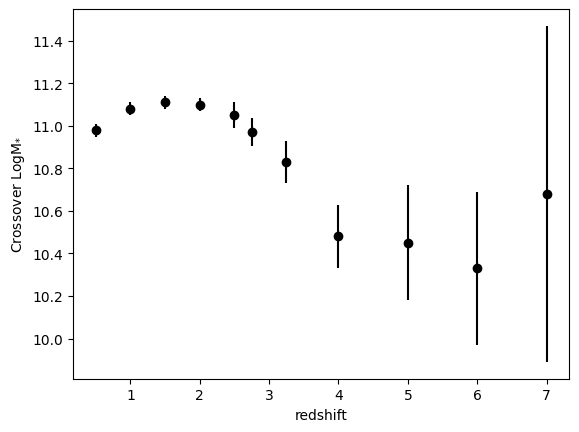

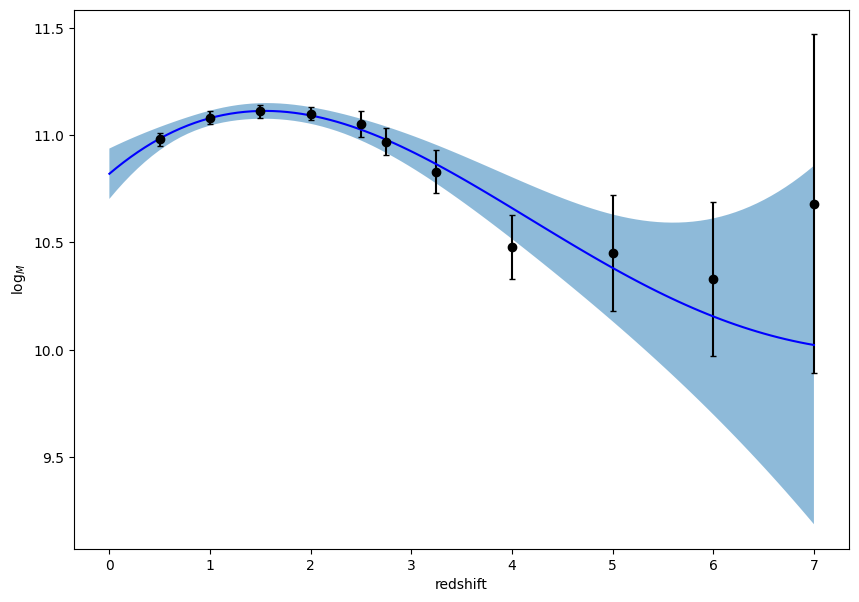

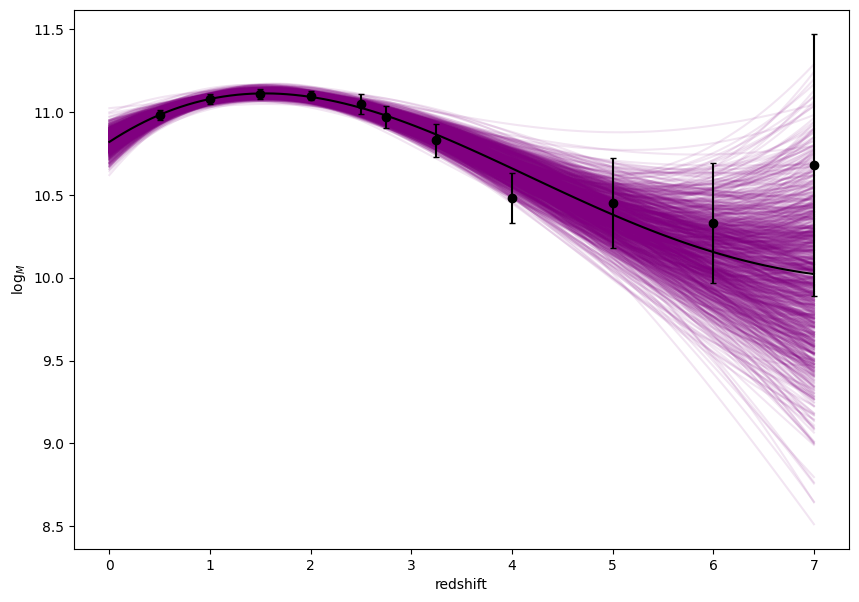

In [4]:
sorted_train_redshift, sorted_train_logm, sorted_train_logm_errs = gpmf.get_logm_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_logm, sorted_train_logm_errs, torch.linspace(0, 7, 100), lengthscale=[2.0, 9999.0], scalefactor=[-999, 999], lr=0.1, training_iter=10000, ylabel="$\mathrm{log}_{M}$", name="logm")